# MLNN Hackathon 2025
# Building Smart Image Classification Models

Imagine you’re part of a team at a tech company working on cool projects like automatic image recognition. Your job is to build a smart image classifier using the given dataset:

1. SVHN (Street View House Numbers): A dataset of digits (0-9) extracted from real-world street view images, with challenges like cluttered backgrounds and overlapping numbers. https://www.tensorflow.org/datasets/catalog/svhn_cropped
http://ufldl.stanford.edu/housenumbers/


Your goal is to explore the dataset, build a model using pre-trained deep learning techniques, and make it as accurate as possible. You’ll need to think about how to handle the challenges the dataset might throw at you and document your process along the way.

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg19 import preprocess_input, VGG19
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import layers, models
from sklearn import model_selection, preprocessing, metrics
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.image import resize
from tensorflow.keras.applications.vgg19 import preprocess_input

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/73257 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/incomplete.P81JPW_3.1.0/svhn_cropped-train.tfrecord*...:   0%…

Generating test examples...:   0%|          | 0/26032 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/incomplete.P81JPW_3.1.0/svhn_cropped-test.tfrecord*...:   0%|…

Generating extra examples...:   0%|          | 0/531131 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/incomplete.P81JPW_3.1.0/svhn_cropped-extra.tfrecord*...:   0%…

Dataset svhn_cropped downloaded and prepared to /root/tensorflow_datasets/svhn_cropped/3.1.0. Subsequent calls will reuse this data.
SVHN Dataset Info:
Number of training examples: 73257
Number of test examples: 26032
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Subset Training data shape: (5000, 32, 32, 3)
Subset Test data shape: (5000, 32, 32, 3)


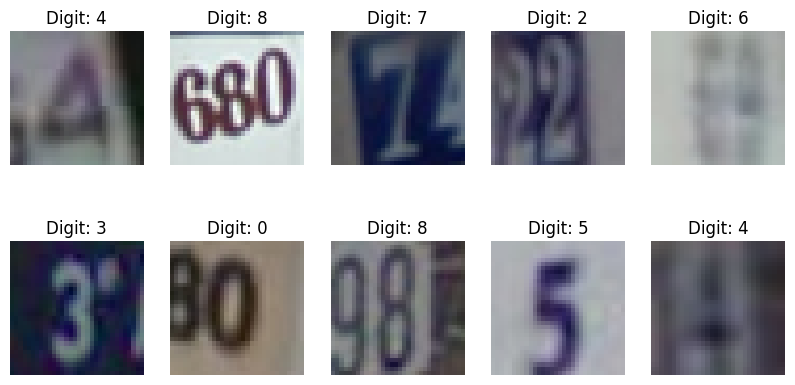

In [ ]:
# Load SVHN Dataset
dataset, info = tfds.load('svhn_cropped', as_supervised=True, with_info=True)

train_dataset = dataset['train']
test_dataset = dataset['test']

print("SVHN Dataset Info:")
print(f"Number of training examples: {info.splits['train'].num_examples}")
print(f"Number of test examples: {info.splits['test'].num_examples}")
print(f"Classes: {info.features['label'].names}")

# Convert Dataset to NumPy for Subsetting
def convert_to_numpy(tf_dataset, num_samples=None):
    """Convert a TF dataset to NumPy arrays."""
    images, labels = [], []
    for img, label in tf_dataset.take(num_samples or -1):
        images.append(img.numpy())
        labels.append(label.numpy())
    return np.array(images), np.array(labels)

# Subset the Dataset if Needed
max_samples = 5000  # Adjust this as needed
x_train, y_train = convert_to_numpy(train_dataset, num_samples=max_samples)
x_test, y_test = convert_to_numpy(test_dataset, num_samples=max_samples)

print(f"Subset Training data shape: {x_train.shape}")
print(f"Subset Test data shape: {x_test.shape}")

# Visualize Sample Images from the Subset
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i])
    plt.title(f"Digit: {y_train[i]}")
    plt.axis('off')
plt.show()


# Dataset Exploration

In [ ]:
# Count class distribution for both training and test sets
def count_class_distribution(y):
    unique, counts = np.unique(y, return_counts=True)
    for digit, count in zip(unique, counts):
        print(f"Digit {digit}: {count} samples")
    return unique, counts

print("Training Set Class Counts:")
train_unique, train_counts = count_class_distribution(y_train)

print("\nTest Set Class Counts:")
test_unique, test_counts = count_class_distribution(y_test)

Training Set Class Counts:
Digit 0: 354 samples
Digit 1: 953 samples
Digit 2: 665 samples
Digit 3: 572 samples
Digit 4: 530 samples
Digit 5: 455 samples
Digit 6: 395 samples
Digit 7: 398 samples
Digit 8: 344 samples
Digit 9: 334 samples

Test Set Class Counts:
Digit 0: 332 samples
Digit 1: 1024 samples
Digit 2: 792 samples
Digit 3: 544 samples
Digit 4: 472 samples
Digit 5: 451 samples
Digit 6: 387 samples
Digit 7: 381 samples
Digit 8: 298 samples
Digit 9: 319 samples


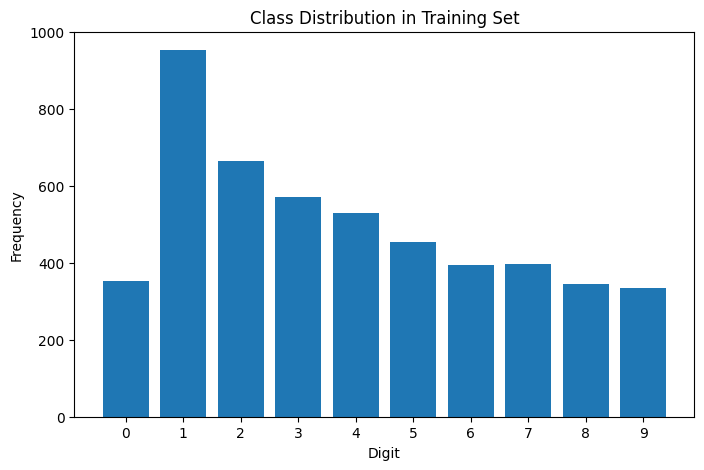

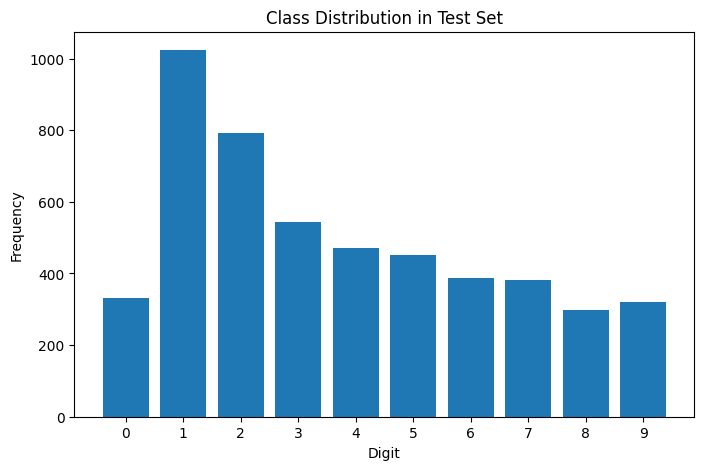

In [ ]:
# Plot class distribution for both sets
def plot_class_distribution(unique, counts, title):
    plt.figure(figsize=(8, 5))
    plt.bar(unique, counts, tick_label=unique)
    plt.title(f"Class Distribution in {title}")
    plt.xlabel("Digit")
    plt.ylabel("Frequency")
    plt.show()

# Display plots separately
plot_class_distribution(train_unique, train_counts, "Training Set")
plot_class_distribution(test_unique, test_counts, "Test Set")

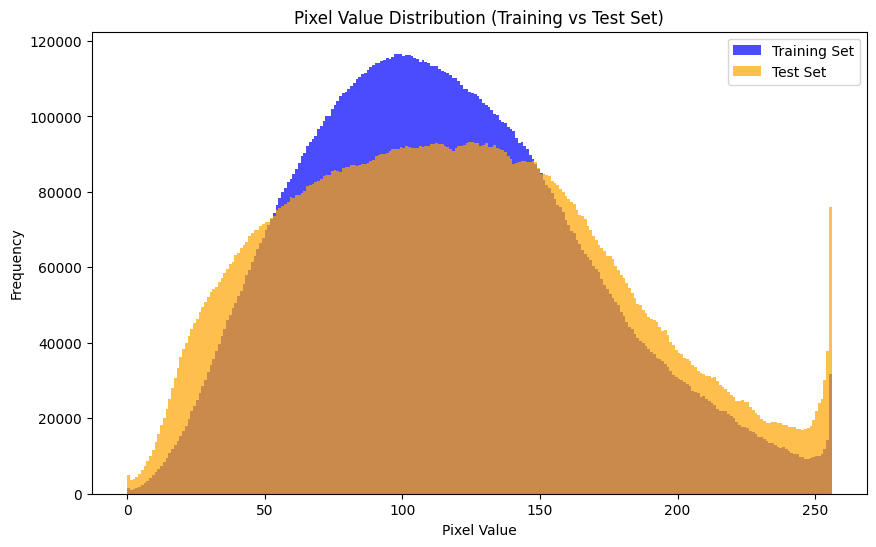

In [ ]:
# Flatten both training and test sets
train_pixels = x_train.flatten()
test_pixels = x_test.flatten()

# Plot histograms for both datasets together
plt.figure(figsize=(10, 6))
plt.hist(train_pixels, bins=256, range=(0, 256), alpha=0.7, label="Training Set", color='blue')
plt.hist(test_pixels, bins=256, range=(0, 256), alpha=0.7, label="Test Set", color='orange')
plt.title("Pixel Value Distribution (Training vs Test Set)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Preprocessing

In order to enable the model to effectively classify images in the dataset,
we first preprocess the data to ensure it is properly formatted for training.

### Normalize and Resize images

To prepare the images for input into the model, we resize them to the required dimensions and normalize their pixel values, ensuring they are properly formatted for model compatibility.

In [ ]:
def preprocess_images_vgg19(images):
    """
    Preprocess images for input into the VGG19 model:
    - Resizes all images to 224x224 pixels, the required input size for VGG19.
    - Applies VGG19-specific normalization, scaling pixel values to the range [-1, 1]
      based on ImageNet dataset statistics
    """
    resized_images = np.array([resize(img, (224, 224)).numpy() for img in images])
    preprocessed_images = preprocess_input(resized_images)  # VGG19 scaling
    return preprocessed_images

# Apply the preprocessing steps to the dataset
x_train_preprocessed = preprocess_images_vgg19(x_train)
x_test_preprocessed = preprocess_images_vgg19(x_test)

# Confirm the preprocessing results
print(f"Training Data Shape: {x_train_preprocessed.shape}")
print(f"Test Data Shape: {x_test_preprocessed.shape}")

Training Data Shape: (5000, 224, 224, 3)
Test Data Shape: (5000, 224, 224, 3)


### One-Hot Encoding

To ensure the model correctly interprets the class labels during training, we apply one-hot encoding which converts the categorical labels into a binary matrix format suitable for multi-class classification.

In [ ]:
# One-hot encoding for labels
def preprocess_labels(labels):
    return to_categorical(labels, num_classes=10)

# Apply preprocessing
x_train_preprocessed = preprocess_images_vgg19(x_train)
x_test_preprocessed = preprocess_images_vgg19(x_test)
y_train_preprocessed = preprocess_labels(y_train)
y_test_preprocessed = preprocess_labels(y_test)

Training Labels Shape: (5000, 10)
Test Labels Shape: (5000, 10)


In [ ]:
# Automatically calculate class weights using sklearn
from sklearn.utils.class_weight import compute_class_weight
# Compute class weights using sklearn for imbalance handling
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.flatten())
class_weights_dict = dict(enumerate(class_weights))

# Display the computed class weights
print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.4124293785310735, 1: 0.5246589716684156, 2: 0.7518796992481203, 3: 0.8741258741258742, 4: 0.9433962264150944, 5: 1.098901098901099, 6: 1.2658227848101267, 7: 1.256281407035176, 8: 1.4534883720930232, 9: 1.4970059880239521}


# Model Training

In [ ]:
# Load the VGG19 model with pre-trained weights
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze all layers initially

# Build the model with GlobalAveragePooling and Dropout
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),  # Reduced dropout for balanced regularization
    layers.Dense(10, activation='softmax')
])

# Compile the model with a reduced learning rate and additional metrics
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

# Display the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,158,282 (76.90 MB)

 Trainable params: 133,898 (523.04 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
# Define callbacks for early stopping and learning rate reduction
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=1e-6)
]

In [ ]:
# Train the model using class weights and reduced batch size
history = model.fit(
    x_train_preprocessed,
    y_train_preprocessed,
    validation_split=0.2,
    epochs=20,
    batch_size=16,                      # Reduced batch size for memory efficiency
    class_weight=class_weights_dict,    # Apply class weighting
    callbacks=callbacks
)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.1240 - auc: 0.5446 - loss: 4.0038 - precision: 0.1332 - recall: 0.0745 - val_accuracy: 0.2280 - val_auc: 0.6928 - val_loss: 2.2440 - val_precision: 0.3349 - val_recall: 0.0730 - learning_rate: 1.0000e-04
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.2122 - auc: 0.6694 - loss: 2.5880 - precision: 0.2667 - recall: 0.1092 - val_accuracy: 0.3230 - val_auc: 0.7708 - val_loss: 1.9188 - val_precision: 0.5194 - val_recall: 0.1070 - learning_rate: 1.0000e-04
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.3185 - auc: 0.7517 - loss: 2.0845 - precision: 0.4561 - recall: 0.1629 - val_accuracy: 0.3420 - val_auc: 0.7959 - val_loss: 1.8184 - val_precision: 0.5773 - val_recall: 0.1270 - learning_rate: 1.0000e-04
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.3677 - auc: 0.7983 - loss: 1.8237 - precision: 0.5492 - recall: 0.1867 - val_accuracy: 0.3860 - val_auc: 0.8205 - val_

In [ ]:
# Evaluate the Model on the Test Set
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(x_test_preprocessed, y_test_preprocessed)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.7636 - auc_1: 0.9600 - loss: 0.8727 - precision_1: 0.8083 - recall_1: 0.7377

Test Accuracy: 0.7610
Test Precision: 0.8059
Test Recall: 0.7332
Test AUC: 0.9592


# Hyperparameter Tunning

In [ ]:
# Unfreeze the last few layers for fine-tuning
base_model.trainable = True

# Freeze all layers except the last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

# Fine-tune the model with the same class weights
fine_tune_history = model.fit(
    x_train_preprocessed,
    y_train_preprocessed,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.7351 - auc_1: 0.9637 - loss: 0.7683 - precision_1: 0.8561 - recall_1: 0.5987 - val_accuracy: 0.6450 - val_auc_1: 0.9284 - val_loss: 1.1114 - val_precision_1: 0.7710 - val_recall_1: 0.5320 - learning_rate: 1.0000e-05
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.8412 - auc_1: 0.9868 - loss: 0.4618 - precision_1: 0.9079 - recall_1: 0.7646 - val_accuracy: 0.6810 - val_auc_1: 0.9387 - val_loss: 1.0364 - val_precision_1: 0.7723 - val_recall_1: 0.6070 - learning_rate: 1.0000e-05
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.8906 - auc_1: 0.9941 - loss: 0.3192 - precision_1: 0.9426 - recall_1: 0.8391 - val_accuracy: 0.7020 - val_auc_1: 0.9455 - val_loss: 0.9814 - val_precision_1: 0.7666 - val_recall_1: 0.6340 - learning_rate: 1.0000e-05
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.9339 - auc_1: 0.9975 - loss: 0.2152 - precision_1: 0.9599 - recall_1: 0.8956 - v

# Model Evaluation

157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       332
           1       0.86      0.85      0.85      1024
           2       0.82      0.83      0.82       792
           3       0.64      0.58      0.61       544
           4       0.73      0.83      0.78       472
           5       0.71      0.71      0.71       451
           6       0.69      0.71      0.70       387
           7       0.79      0.76      0.77       381
           8       0.64      0.69      0.67       298
           9       0.76      0.71      0.73       319

    accuracy                           0.76      5000
   macro avg       0.74      0.74      0.74      5000
weighted avg       0.76      0.76      0.76      5000



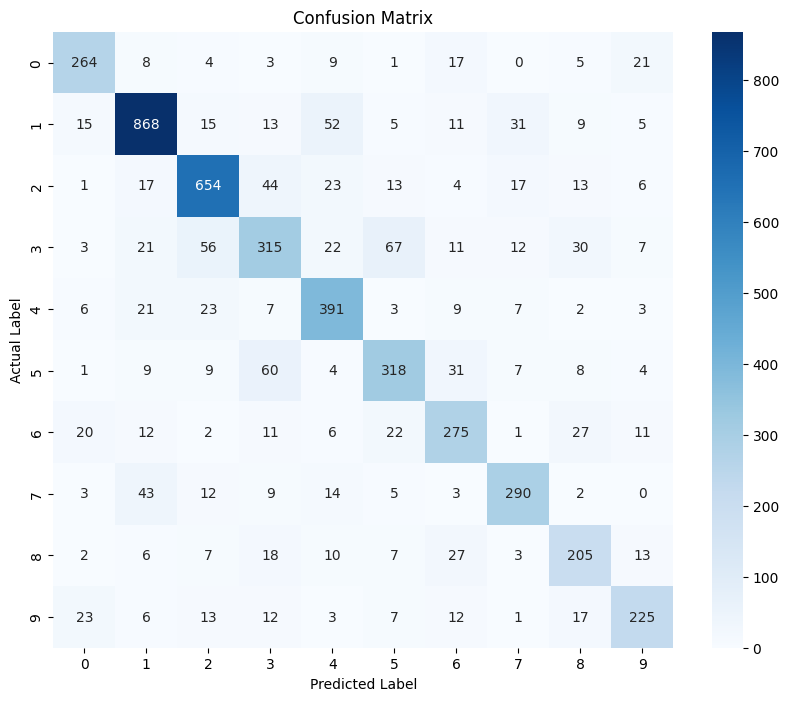

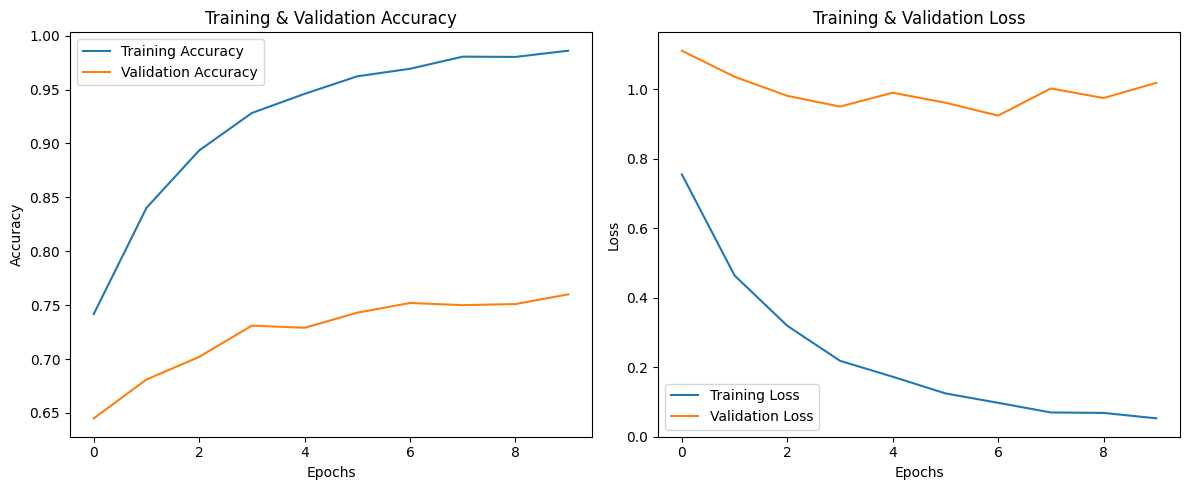

In [ ]:
# Generate Predictions for Evaluation
predictions = np.argmax(model.predict(x_test_preprocessed), axis=1)
y_true = np.argmax(y_test_preprocessed, axis=1)

# Generate a Classification Report
print("\nClassification Report:")
print(classification_report(y_true, predictions))

# Generate and Visualize the Confusion Matrix
conf_matrix = confusion_matrix(y_true, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot Training Curves for Accuracy and Loss
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the Function to Visualize Training Performance
plot_training_curves(history)


# Model Evaliuation for Hyperparameter Tunning

In [ ]:
# Evaluate hyperparameter tuning
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict on validation set
y_pred = model.predict(x_train_preprocessed)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_train_preprocessed, axis=1)

# Generate classification report
report = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:\n", report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

# Evaluate model performance
results = model.evaluate(x_train_preprocessed, y_train_preprocessed, batch_size=16)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95       354
           1       0.95      0.97      0.96       953
           2       0.96      0.96      0.96       665
           3       0.94      0.93      0.94       572
           4       0.95      0.96      0.96       530
           5       0.91      0.95      0.93       455
           6       0.95      0.94      0.94       395
           7       0.96      0.94      0.95       398
           8       0.92      0.93      0.93       344
           9       0.98      0.88      0.93       334

    accuracy                           0.95      5000
   macro avg       0.95      0.94      0.94      5000
weighted avg       0.95      0.95      0.95      5000

Confusion Matrix:
 [[344   3   0   1   2   0   0   0   4   0]
 [  3 920   3   3   8   3   4   5   2   2]
 [  0   5 638   7   5   4   1   2   1   2]
 [  1   3  12 531   3  12  

Predictions

In [ ]:
# Save the trained model in HDF5 format
model.save('svhn_vgg19_model.h5')

print("Model saved successfully as 'svhn_vgg19_model.h5'")

Model saved successfully as 'svhn_vgg19_model.h5'


In [ ]:
from tensorflow.keras.models import load_model

# Load the model from the saved file
loaded_model = load_model('svhn_vgg19_model.h5')

# Confirm model architecture
loaded_model.summary()
print(" Model loaded successfully!")

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,124,364 (84.40 MB)

 Trainable params: 2,099,978 (8.01 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

 Optimizer params: 2 (12.00 B)

 Model loaded successfully!


In [ ]:
# Generate predictions using the loaded model on the test set
predictions = np.argmax(loaded_model.predict(x_test_preprocessed), axis=1)

# Print a few sample predictions with their true labels
for i in range(10):
    print(f"Predicted: {predictions[i]}, Actual: {np.argmax(y_test_preprocessed[i])}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step
Predicted: 4, Actual: 2
Predicted: 7, Actual: 7
Predicted: 2, Actual: 2
Predicted: 4, Actual: 4
Predicted: 4, Actual: 4
Predicted: 2, Actual: 2
Predicted: 6, Actual: 6
Predicted: 2, Actual: 2
Predicted: 3, Actual: 3
Predicted: 1, Actual: 1


In [ ]:
def predict_image_class(image):
    """
    Function to predict the class of a new image using the trained VGG19 model.
    Args:
    - image: Raw image array (32x32 or any size)

    Returns:
    - Predicted class label (0-9)
    """
    # Ensure the image is resized and preprocessed for VGG19
    image_resized = resize(image, (128, 128))
    image_preprocessed = preprocess_input(image_resized.numpy())
    image_preprocessed = np.expand_dims(image_preprocessed, axis=0)  # Add batch dimension

    # Predict using the loaded model
    prediction = np.argmax(loaded_model.predict(image_preprocessed), axis=1)[0]
    return prediction

# Example of using the function with a test image
sample_image = x_test[0]  # Selecting a test image
predicted_label = predict_image_class(sample_image)
print(f"\n Predicted Label for Sample Image: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

 Predicted Label for Sample Image: 4


In [ ]:
# Evaluate the loaded model to ensure consistency
test_loss, test_accuracy, test_precision, test_recall, test_auc = loaded_model.evaluate(x_test_preprocessed, y_test_preprocessed)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.6742 - auc_6: 0.9401 - loss: 1.0340 - precision_6: 0.8018 - recall_6: 0.5651

Test Accuracy: 0.6724
Test Precision: 0.8057
Test Recall: 0.5714
Test AUC: 0.9416


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


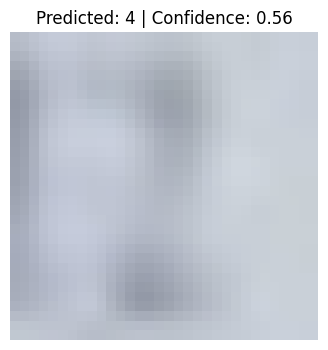

In [ ]:


def predict_and_plot_image(image):
    """
    Function to predict the class of a new image and display it with the predicted label.
    Args:
    - image: Raw image array (32x32 or any size)

    Returns:
    - Predicted class label (0-9) and confidence score
    """
    # Convert image to float32 if needed
    if image.dtype != np.float32:
        image = image.astype(np.float32)

    # Ensure the image is resized and preprocessed for VGG19
    image_resized = resize(image, (128, 128))
    image_preprocessed = preprocess_input(image_resized)
    image_preprocessed = np.expand_dims(image_preprocessed, axis=0)

    # Predict using the loaded model
    prediction_probs = loaded_model.predict(image_preprocessed)
    predicted_label = np.argmax(prediction_probs, axis=1)[0]
    confidence = np.max(prediction_probs)  # Added confidence score

    #  Plot the image with prediction
    plt.figure(figsize=(4, 4))
    plt.imshow(image.astype("uint8"))
    plt.title(f"Predicted: {predicted_label} | Confidence: {confidence:.2f}")
    plt.axis('off')
    plt.show()

    return predicted_label, confidence

#  Test the function with a sample image from the test set
sample_image = x_test[0]
predicted_label, confidence = predict_and_plot_image(sample_image)